In [1]:
%load_ext autoreload
%autoreload 2

In [6]:
import re
from dataset import COCOPanopticDataset, COCODataLoader, COCOPanopticExample
from copy import copy, deepcopy
import json
from PIL import Image
import pickle as pkl

from gradio_pww import unpack_layers
import psd_tools
import numpy as np
import torch

In [3]:
def segmap_from_layers(layers, globalprompt):
    ret = None
    retdict = {}
    for i, layer in enumerate(layers):
        randomcolor = torch.randint(0, 256, (3,))     # RGB
        code = randomcolor[0].item() + randomcolor[1].item() * 256 + randomcolor[2].item() * (256**2)
        if f":{i}}}" in globalprompt:
            globalprompt = re.sub(f"\:{i}\\}}", f":{code}}}", globalprompt)
        mask = layer[(512,512)]
        maskcolor = mask.unsqueeze(-1).repeat(1, 1, 3) * randomcolor[None, None, :]
        if ret is None:
            ret = torch.zeros_like(maskcolor)
        ret = torch.where(mask.unsqueeze(-1) > 0.5, maskcolor, ret)
        retdict[code] = {"caption": layer["pos"]}
        
    ret = (ret).to(torch.long).cpu().numpy()
    
    return ret, retdict, globalprompt

def psd_to_cocopanoptic(fp):
    layers = psd_tools.PSDImage.open(fp)
    spec = unpack_layers(layers)
    segmap, prompts, globalprompt = segmap_from_layers(spec["layers"], spec["global"]["pos"])
    img = Image.fromarray(segmap.astype(np.uint8))
    ret = COCOPanopticExample(
        id=-1,
        img=img,
        captions=[globalprompt],
        seg_img=img,
        seg_info=prompts,
        cropsize=512
    )
    return ret

def display_example(x):
    display(x.load_seg_image())
    print(x.captions)
    print(repr(x.seg_info))


In [4]:
# examples with three circular shapes
threecirclesexamples = []

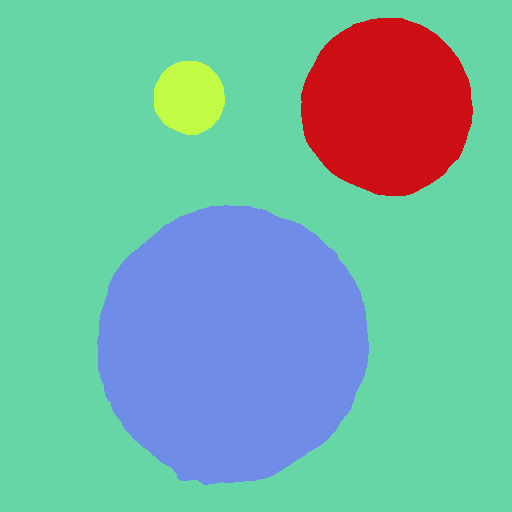

['a highly detailed photorealistic image of {a gold coin:4586434}, {a blue crystal ball:15175023} and {a red tennis ball:1380301} on {a wooden table:10999398}.']
{10999398: {'caption': 'a highly detailed photorealistic image of a wooden table'}, 1380301: {'caption': 'a highly detailed photorealistic image of a red tennis ball'}, 15175023: {'caption': 'a highly detailed photorealistic image of a blue crystal ball'}, 4586434: {'caption': 'a highly detailed photorealistic image of a gold coin'}}


In [16]:
fp = '/USERSPACE/lukovdg1/datasets2/datasets/images/balls2.psd'

example = psd_to_cocopanoptic(fp)
display_example(example)

In [17]:
# create prototype from example

def replace_in_captions(x, repls):
    newcaptions = []
    for caption in x.captions:
        for k, v in repls.items():
            caption = caption.replace(k, v)
        newcaptions.append(caption)

    new_seg_info = {}
    for regioncode, regioninfo in x.seg_info.items():
        caption = regioninfo["caption"]
        for k, v in repls.items():
            caption = caption.replace(k, v)
        new_seg_info[regioncode] = {"caption": caption}

    ret = deepcopy(x)
    ret.captions = newcaptions
    ret.seg_info = new_seg_info
    return ret

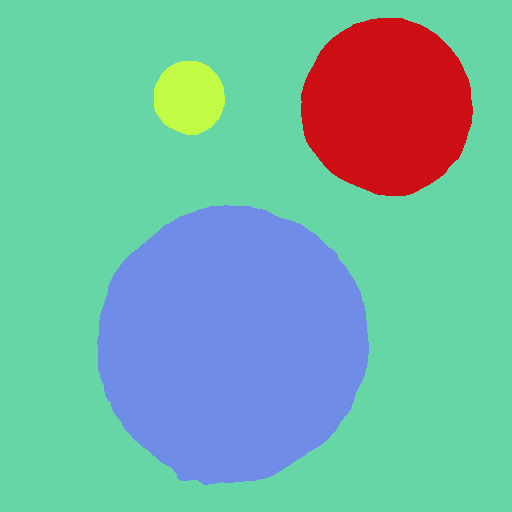

['a highly detailed photorealistic image of {<OBJ_A>:4586434}, {<OBJ_B>:15175023} and {<OBJ_C>:1380301} on {<OBJ_D>:10999398}.']
{10999398: {'caption': 'a highly detailed photorealistic image of <OBJ_D>'}, 1380301: {'caption': 'a highly detailed photorealistic image of <OBJ_C>'}, 15175023: {'caption': 'a highly detailed photorealistic image of <OBJ_B>'}, 4586434: {'caption': 'a highly detailed photorealistic image of <OBJ_A>'}}


In [18]:
repls = {
    "a gold coin": "<OBJ_A>",
    "a blue crystal ball": "<OBJ_B>",
    "a red tennis ball": "<OBJ_C>",
    "a wooden table": "<OBJ_D>"
}
prototype = replace_in_captions(example, repls)
display_example(prototype)

In [19]:
import random
import itertools

random.seed(42)

In [27]:
# setting one: balls
objects = ["a {color} crystal ball", "a {color} tennis ball", "a {color} ping pong ball"]
object_colors = ["red", "blue", "yellow"]
backgrounds = ["a wooden table", "grass"]

retspecs = []

# iterate through possible permutations
specs = []
for bgr in backgrounds:
    spec = {"<OBJ_D>": bgr}
    for objperm in itertools.permutations(objects, 3):
        # print(objperm)
        for colorperm in itertools.permutations(object_colors, 3):
            for posname, obj, color in zip(["<OBJ_A>", "<OBJ_B>", "<OBJ_C>"], objperm, colorperm):
                spec[posname] = obj.format(color=color)
            specs.append(deepcopy(spec))
            
print(len(specs))
random.shuffle(specs)
specs = specs[:10]
retspecs += specs

for spec in specs:
    print(spec)
    
    
# iterate through possible combinations
specs = []
for bgr in backgrounds:
    spec = {"<OBJ_D>": bgr}
    specset = set()
    for objperm in itertools.combinations_with_replacement(objects, 3):
        # print(objperm)
        _spec = deepcopy(spec)
        for colorperm in itertools.combinations_with_replacement(object_colors, 3):
            for posname, obj, color in zip(["<OBJ_A>", "<OBJ_B>", "<OBJ_C>"], objperm, colorperm):
                _spec[posname] = obj.format(color=color)
            specset = set(_spec.values())
            if len(specset) < len(_spec):
                continue
            specs.append(deepcopy(_spec))
            
print(len(specs))
random.shuffle(specs)
specs = specs[:10]
retspecs += specs

for spec in specs:
    print(spec)
            

72
{'<OBJ_D>': 'grass', '<OBJ_A>': 'a red crystal ball', '<OBJ_B>': 'a yellow ping pong ball', '<OBJ_C>': 'a blue tennis ball'}
{'<OBJ_D>': 'a wooden table', '<OBJ_A>': 'a blue crystal ball', '<OBJ_B>': 'a red ping pong ball', '<OBJ_C>': 'a yellow tennis ball'}
{'<OBJ_D>': 'a wooden table', '<OBJ_A>': 'a blue tennis ball', '<OBJ_B>': 'a yellow crystal ball', '<OBJ_C>': 'a red ping pong ball'}
{'<OBJ_D>': 'grass', '<OBJ_A>': 'a blue tennis ball', '<OBJ_B>': 'a red crystal ball', '<OBJ_C>': 'a yellow ping pong ball'}
{'<OBJ_D>': 'a wooden table', '<OBJ_A>': 'a blue ping pong ball', '<OBJ_B>': 'a red tennis ball', '<OBJ_C>': 'a yellow crystal ball'}
{'<OBJ_D>': 'a wooden table', '<OBJ_A>': 'a yellow crystal ball', '<OBJ_B>': 'a blue ping pong ball', '<OBJ_C>': 'a red tennis ball'}
{'<OBJ_D>': 'a wooden table', '<OBJ_A>': 'a blue tennis ball', '<OBJ_B>': 'a red ping pong ball', '<OBJ_C>': 'a yellow crystal ball'}
{'<OBJ_D>': 'a wooden table', '<OBJ_A>': 'a yellow ping pong ball', '<OBJ_B>'

In [28]:
examples = []
for spec in retspecs:
    x = replace_in_captions(prototype, spec)
    # display_example(x)
    examples.append(x)
    
with open("threeballs.variants.pkl", "wb") as f:
    pkl.dump(examples, f)
    


In [30]:
# setting one: fruits
objects = ["a {color} orange", "a {color} apple", "a {color} watermelon"]
object_colors = ["red", "green", "yellow"]
backgrounds = ["a kitchen table", "grass", "a fruit basket"]

retspecs = []

# iterate through possible permutations
specs = []
for bgr in backgrounds:
    spec = {"<OBJ_D>": bgr}
    for objperm in itertools.permutations(objects, 3):
        # print(objperm)
        for colorperm in itertools.permutations(object_colors, 3):
            for posname, obj, color in zip(["<OBJ_A>", "<OBJ_B>", "<OBJ_C>"], objperm, colorperm):
                spec[posname] = obj.format(color=color)
            specs.append(deepcopy(spec))
            
print(len(specs))
random.shuffle(specs)
specs = specs[:10]
retspecs += specs

for spec in specs:
    print(spec)
    
    
# iterate through possible combinations
specs = []
for bgr in backgrounds:
    spec = {"<OBJ_D>": bgr}
    specset = set()
    for objperm in itertools.combinations_with_replacement(objects, 3):
        # print(objperm)
        _spec = deepcopy(spec)
        for colorperm in itertools.combinations_with_replacement(object_colors, 3):
            for posname, obj, color in zip(["<OBJ_A>", "<OBJ_B>", "<OBJ_C>"], objperm, colorperm):
                _spec[posname] = obj.format(color=color)
            specset = set(_spec.values())
            if len(specset) < len(_spec):
                continue
            specs.append(deepcopy(_spec))
            
print(len(specs))
random.shuffle(specs)
specs = specs[:10]
retspecs += specs

for spec in specs:
    print(spec)
            

108
{'<OBJ_D>': 'a fruit basket', '<OBJ_A>': 'a green watermelon', '<OBJ_B>': 'a yellow orange', '<OBJ_C>': 'a red apple'}
{'<OBJ_D>': 'a fruit basket', '<OBJ_A>': 'a green orange', '<OBJ_B>': 'a red watermelon', '<OBJ_C>': 'a yellow apple'}
{'<OBJ_D>': 'a fruit basket', '<OBJ_A>': 'a green watermelon', '<OBJ_B>': 'a yellow apple', '<OBJ_C>': 'a red orange'}
{'<OBJ_D>': 'a fruit basket', '<OBJ_A>': 'a green apple', '<OBJ_B>': 'a yellow watermelon', '<OBJ_C>': 'a red orange'}
{'<OBJ_D>': 'a fruit basket', '<OBJ_A>': 'a red apple', '<OBJ_B>': 'a green orange', '<OBJ_C>': 'a yellow watermelon'}
{'<OBJ_D>': 'grass', '<OBJ_A>': 'a red orange', '<OBJ_B>': 'a yellow apple', '<OBJ_C>': 'a green watermelon'}
{'<OBJ_D>': 'a fruit basket', '<OBJ_A>': 'a yellow watermelon', '<OBJ_B>': 'a red orange', '<OBJ_C>': 'a green apple'}
{'<OBJ_D>': 'a kitchen table', '<OBJ_A>': 'a green apple', '<OBJ_B>': 'a yellow watermelon', '<OBJ_C>': 'a red orange'}
{'<OBJ_D>': 'a fruit basket', '<OBJ_A>': 'a red oran

In [31]:
examples = []
for spec in retspecs:
    x = replace_in_captions(prototype, spec)
    # display_example(x)
    examples.append(x)
    
with open("threefruits.variants.pkl", "wb") as f:
    pkl.dump(examples, f)
    


In [88]:
# setting one: car 
objects = ["a {color} BMW sign", "a {color} Mercedes sign", "a {color} gold coin"]
object_colors = ["red", "black", "blue"]
backgrounds = ["a table"]

retspecs = []

# iterate through possible permutations
specs = []
for bgr in backgrounds:
    spec = {"<OBJ_D>": bgr}
    for objperm in itertools.permutations(objects, 3):
        # print(objperm)
        for colorperm in itertools.permutations(object_colors, 3):
            for posname, obj, color in zip(["<OBJ_A>", "<OBJ_B>", "<OBJ_C>"], objperm, colorperm):
                spec[posname] = obj.format(color=color)
            specs.append(deepcopy(spec))
            
print(len(specs))
random.shuffle(specs)
specs = specs[:10]
retspecs += specs

for spec in specs:
    print(spec)
    
    
# iterate through possible combinations
specs = []
for bgr in backgrounds:
    spec = {"<OBJ_D>": bgr}
    for objperm in itertools.combinations_with_replacement(objects, 3):
        # print(objperm)
        for colorperm in itertools.combinations_with_replacement(object_colors, 3):
            for posname, obj, color in zip(["<OBJ_A>", "<OBJ_B>", "<OBJ_C>"], objperm, colorperm):
                spec[posname] = obj.format(color=color)
            specs.append(deepcopy(spec))
            
print(len(specs))
random.shuffle(specs)
specs = specs[:10]
retspecs += specs

for spec in specs:
    print(spec)
            

36
{'<OBJ_D>': 'a table', '<OBJ_A>': 'a blue BMW sign', '<OBJ_B>': 'a black Mercedes sign', '<OBJ_C>': 'a red gold coin'}
{'<OBJ_D>': 'a table', '<OBJ_A>': 'a black Mercedes sign', '<OBJ_B>': 'a red gold coin', '<OBJ_C>': 'a blue BMW sign'}
{'<OBJ_D>': 'a table', '<OBJ_A>': 'a black gold coin', '<OBJ_B>': 'a blue BMW sign', '<OBJ_C>': 'a red Mercedes sign'}
{'<OBJ_D>': 'a table', '<OBJ_A>': 'a blue Mercedes sign', '<OBJ_B>': 'a red BMW sign', '<OBJ_C>': 'a black gold coin'}
{'<OBJ_D>': 'a table', '<OBJ_A>': 'a blue BMW sign', '<OBJ_B>': 'a black gold coin', '<OBJ_C>': 'a red Mercedes sign'}
{'<OBJ_D>': 'a table', '<OBJ_A>': 'a black Mercedes sign', '<OBJ_B>': 'a blue BMW sign', '<OBJ_C>': 'a red gold coin'}
{'<OBJ_D>': 'a table', '<OBJ_A>': 'a blue gold coin', '<OBJ_B>': 'a red Mercedes sign', '<OBJ_C>': 'a black BMW sign'}
{'<OBJ_D>': 'a table', '<OBJ_A>': 'a black gold coin', '<OBJ_B>': 'a red Mercedes sign', '<OBJ_C>': 'a blue BMW sign'}
{'<OBJ_D>': 'a table', '<OBJ_A>': 'a blue gol